# Proyecto Mapper: Rutas de Vuelo 2012

En el siguiente proyecto se hará una implementación del algoritmo mapper utilizando una base de datos obtenida de Kaggle del siguiente link: https://www.kaggle.com/datasets/open-flights/flight-route-database
En el link se tiene la siguiente descripción de la base de datos:

-Código de aerolínea Código de 2 letras (IATA) o de 3 letras (ICAO) de la aerolínea.

-ID de aerolínea Identificador único de OpenFlights para la aerolínea.

-Aeropuerto de origen Código de 3 letras (IATA) o de 4 letras (ICAO) del aeropuerto de origen.

-ID del aeropuerto de origen Identificador único de OpenFlights para el aeropuerto de origen.

-Aeropuerto de destino Código de 3 letras (IATA) o de 4 letras (ICAO) del aeropuerto de destino.

-ID del aeropuerto de destino Identificador único de OpenFlights para el aeropuerto de destino.

-Codeshare "Y" si este vuelo es un codeshare (es decir, no operado por la aerolínea, sino por otro transportista), vacío de lo -contrario.

-Paradas Número de paradas en este vuelo ("0" para directo).

-Equipo Códigos de 3 letras para los tipos de avión generalmente utilizados en este vuelo, separados por espacios.

-El valor especial \N se utiliza para "NULL" para indicar que no hay valor disponible.

Primeramente, se importan librerias para trabajar. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Primeramente se obtienen los datos desde el csv.

df = pd.read_csv("routes.csv")
print(df.head())

  airline airline ID source airport source airport id destination apirport  \
0      2B        410            AER              2965                  KZN   
1      2B        410            ASF              2966                  KZN   
2      2B        410            ASF              2966                  MRV   
3      2B        410            CEK              2968                  KZN   
4      2B        410            CEK              2968                  OVB   

  destination airport id codeshare  stops equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2  


Como podemos observar, tenemos varias variables categóricas, unas que probablemente no nos serán muy importantes tales como "Codeshare"

In [3]:
#Dropeamos Codeshare por el index.
column_name = df.columns[6]
df = df.drop(column_name, axis=1)
print(df.head(10))

  airline airline ID source airport source airport id destination apirport  \
0      2B        410            AER              2965                  KZN   
1      2B        410            ASF              2966                  KZN   
2      2B        410            ASF              2966                  MRV   
3      2B        410            CEK              2968                  KZN   
4      2B        410            CEK              2968                  OVB   
5      2B        410            DME              4029                  KZN   
6      2B        410            DME              4029                  NBC   
7      2B        410            DME              4029                  TGK   
8      2B        410            DME              4029                  UUA   
9      2B        410            EGO              6156                  KGD   

  destination airport id  stops equipment  
0                   2990      0       CR2  
1                   2990      0       CR2  
2        

Para una limpieza más profunda de datos, utilizo "drop" para así eliminar las filas en las cuales hay 2 o más valores "NULL". Esto debido a que se puede tolerar uno ya que, por ejemplo, en la fila 7 de arriba, se puede ver que no hay un destination airport id pero sí tenemos su código de 3 letras, por lo que nos sigue sirviendo. Además, específicamente en esta base de datos, los valores nulos se tienen como \N, por lo tanto lo cambio a "NULL"s más comunes que pueda identificar pandas.

In [4]:
df.replace("\\N", np.nan, inplace=True)
#Dropeamos valores null.
df = df.dropna()
print(df.head(10))

   airline airline ID source airport source airport id destination apirport  \
0       2B        410            AER              2965                  KZN   
1       2B        410            ASF              2966                  KZN   
2       2B        410            ASF              2966                  MRV   
3       2B        410            CEK              2968                  KZN   
4       2B        410            CEK              2968                  OVB   
5       2B        410            DME              4029                  KZN   
6       2B        410            DME              4029                  NBC   
8       2B        410            DME              4029                  UUA   
9       2B        410            EGO              6156                  KGD   
10      2B        410            EGO              6156                  KZN   

   destination airport id  stops equipment  
0                    2990      0       CR2  
1                    2990      0       C

In [5]:
#Las variables que nos servirán, las cuales son ID's están como "objects", por lo cual las cambio a "int"
# para no usar ningun encoder.
df[df.columns[1]] = df[df.columns[1]].astype(int)
df[df.columns[3]] = df[df.columns[3]].astype(int) 
df[df.columns[5]] = df[df.columns[5]].astype(int)

print(df.dtypes)

airline                   object
airline ID                 int32
source airport            object
source airport id          int32
destination apirport      object
destination airport id     int32
stops                      int64
equipment                 object
dtype: object


La mayoría de las columnas que tenemos son categóricas y se repiten de cierta forma. "Airline" y "Airline ID" estan relacionadas, ya que el ID pertenece a la "Airline" y así sucesivamente con "Source airport", "Destination airport". Decidí droppear "equipment" para no sobre complicar el modelo.

In [6]:
#Dropeamos columnas que no nos servirán.
df_dropped = df.copy()
column_name= [df_dropped.columns[0], df_dropped.columns[2], df_dropped.columns[4],df_dropped.columns[7]]
df_dropped = df_dropped.drop(column_name, axis=1)
print(df_dropped.head(10))
print(df_dropped.dtypes)

    airline ID  source airport id  destination airport id  stops
0          410               2965                    2990      0
1          410               2966                    2990      0
2          410               2966                    2962      0
3          410               2968                    2990      0
4          410               2968                    4078      0
5          410               4029                    2990      0
6          410               4029                    6969      0
8          410               4029                    6160      0
9          410               6156                    2952      0
10         410               6156                    2990      0
airline ID                int32
source airport id         int32
destination airport id    int32
stops                     int64
dtype: object


## Visualización de datos


Para checar y observar las posibles conexiones que nos podrán salir en el algoritmo mapper, hago un breve análisis general de los datos.

In [7]:
distinct = df[df.columns[2]].nunique()

print(f"Número de aeropuertos: {distinct}")

Número de aeropuertos: 3229


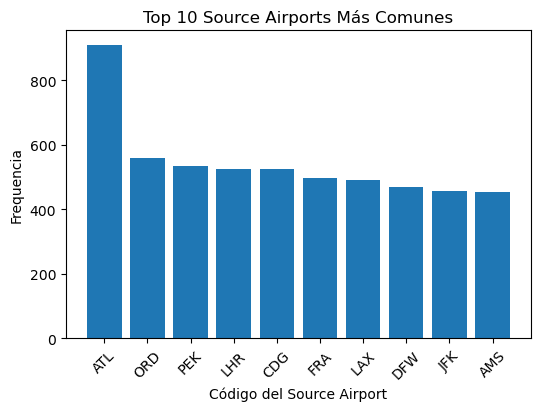

In [8]:
top_airports = df[df.columns[2]].value_counts().head(10)

plt.figure(figsize=(6, 4)) 
plt.bar(top_airports.index, top_airports.values)

plt.title('Top 10 Source Airports Más Comunes')
plt.xlabel('Código del Source Airport')
plt.ylabel('Frequencia')
plt.xticks(rotation=45)
plt.show()

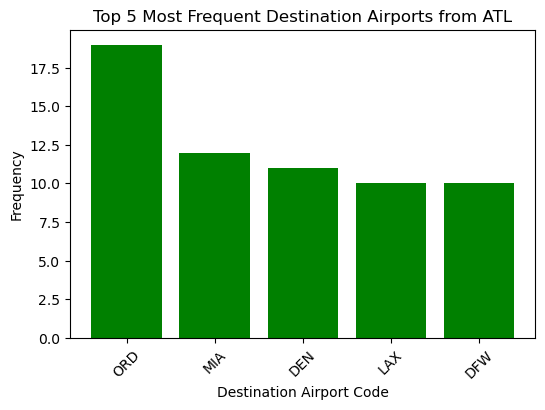

In [9]:
most_common_source = df[df.columns[2]].value_counts().idxmax()
filtered_df = df[df[df.columns[2]] == most_common_source]
top_destination_airports = filtered_df[df.columns[4]].value_counts().head(5)

plt.figure(figsize=(6,4))
plt.bar(top_destination_airports.index, top_destination_airports.values, color='green')

plt.title(f'Top 5 Most Frequent Destination Airports from {most_common_source}')
plt.xlabel('Destination Airport Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

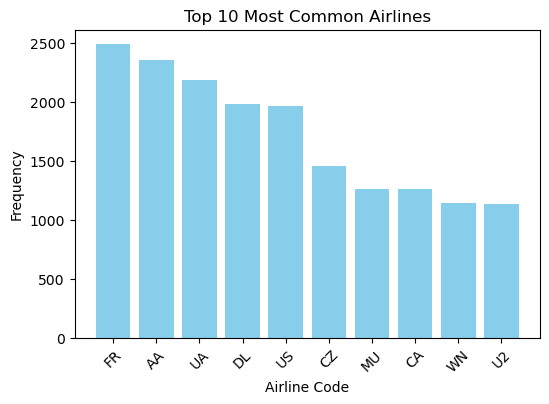

In [10]:
top_airlines = df['airline'].value_counts().head(10)

plt.figure(figsize=(6,4)) 
plt.bar(top_airlines.index, top_airlines.values, color='skyblue')

plt.title('Top 10 Most Common Airlines')
plt.xlabel('Airline Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

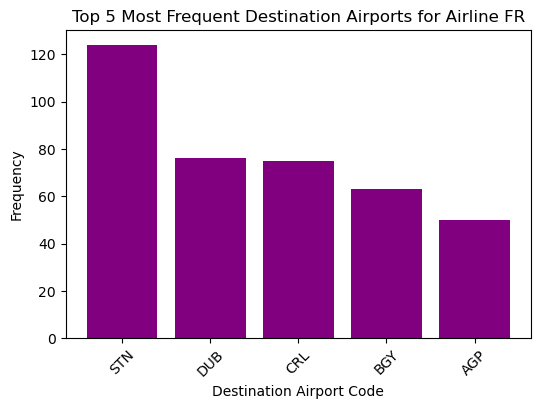

In [11]:
most_common_airline = df['airline'].value_counts().idxmax()
airline_df = df[df['airline'] == most_common_airline]

top_destination_airports = airline_df[df.columns[4]].value_counts().head(5)


plt.figure(figsize=(6,4))
plt.bar(top_destination_airports.index, top_destination_airports.values, color='purple')

plt.title(f'Top 5 Most Frequent Destination Airports for Airline {most_common_airline}')
plt.xlabel('Destination Airport Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.show()

## Implementación algoritmo mapper

Se implementa ahora el algoritmo mapper utilizando el dataframe hecho antes, con la información importante.

In [ ]:
!pip install kmapper

In [13]:
# Para verificar que los datos sean numéricos y que el dataframe no contiene valores nulos.
data = df_dropped
print(type(data))
print(data.dtypes)
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
airline ID                int32
source airport id         int32
destination airport id    int32
stops                     int64
dtype: object
airline ID                0
source airport id         0
destination airport id    0
stops                     0
dtype: int64


In [14]:
# Una última visualización
data

,airline ID,source airport id,destination airport id,stops
0,410,2965,2990,0
1,410,2966,2990,0
2,410,2966,2962,0
3,410,2968,2990,0
4,410,2968,4078,0
...,...,...,...,...
67658,4178,6334,3341,0
67659,19016,4029,2912,0
67660,19016,2912,4029,0
67661,19016,2912,2913,0


In [ ]:
#Imports para el mapper, utilizo la libreria de kmapper para Python.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from kmapper import KeplerMapper, Cover
import warnings

Primeramente los datos se normalizan utilizando StandardScaler, que elimina la media y escala los datos para que tengan una varianza unitaria.

Luego, inicialicé el KepplerMappler con verbose = 1 debido a que quería hacer debugging, ya que al principio me fallaba.

Se utiliza un modelo de PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los datos a tres dimensiones principales. Esto transforma el conjunto de datos original en un conjunto de datos de menor dimensionalidad. Esta fue = 3 debido a que 4 hacía una topología bastante más compleja sin características visibles en común. En cambio, el = 2 hacía que la topología se viera bastante simple, lo que no nos daba suficiente información al respecto. Por lo tanto, 3 me daba una topología bastante suficiente, en la cual se podían observar características en común.

Se define un cover para el espacio de la lente. El cover es una colección de hiperrectángulos que se utilizan para "cubrir" el espacio transformado. Utilicé n_cubes=10 debido a que estos dieron una visualización bastante satisfactoria, misma razón por la que definí el perc_overlap=0.1.

Debido a que el KMeans me daba bastantes advertencias sobre la documentación, preferí usar warnings.catch_warnings(), así se capturan advertencias y con warnings.simplefilter("ignore") se ignoran para evitar que se muestren durante la ejecución del código.

Decidí utilizar KMeans debido a que primeramente utilicé DBSCAN y el algoritmo mapper no funcionó del todo bien. Esto pudo deberse a la forma en la que se calcula el DBSCAN y que en mis datos específicamente haya clasificado bastantes como ruido y outliers. Es debido a esto que preferí utilizar KMeans para hacer aglomerar los datos de una mejor manera. Decidí que fueran 4 clusters debido a que la visualización de 3 clusters no obtuvo muy buenos resultados. 

Finalmente, se utiliza mapper.map para construir el grafo simplicial. Esto crea una representación topológica de los datos basada en la lente de PCA, el cover definido y el clustering realizado por KMeans.

In [15]:
X = StandardScaler().fit_transform(data)

mapper = KeplerMapper(verbose=1)

lens = mapper.fit_transform(X, projection=PCA(n_components=3))

cover = Cover(n_cubes=10, perc_overlap=0.1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    clusterer = KMeans(n_clusters=4)

    
    graph = mapper.map(lens, X, cover=cover, clusterer=clusterer)


KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: PCA(n_components=3)
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (66749, 4)

..Projecting data using: 
	PCA(n_components=3)


..Scaling with: MinMaxScaler()

Mapping on data shaped (66749, 4) using lens shaped (66749, 3)

Creating 1000 hypercubes.


  File "C:\Users\major\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\major\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\major\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\major\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Created 316 edges and 192 nodes in 0:00:20.575935.


In [16]:
mapper.visualize(graph, 
                 path_html="mapper_visualization_flight_ids.html",
                 title="KeplerMapper on Flight ID Data")


Wrote visualization to: mapper_visualization_flight_ids.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>KeplerMapper on Flight ID Data | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13

![Mapper](algomapper.png)

## Análisis

La visualización muestra una estructura de red compleja con 192 nodos y 316 aristas, lo que indica una variedad de caminos e interconexiones entre diferentes aeropuertos/rutas.

Agrupaciones y Centros de Conexión: La presencia de agrupacionespodría representar grupos de aeropuertos que comparten características comunes, como el volumen de tráfico. Los nodos más grandes podrían significar centros de aeropuertos con un mayor número de vuelos como destinos o salidas.

Vuelos Directos vs. Con Escalas: Los datos incluyen un atributo "stops" que indica si un vuelo es directo o tiene escalas. Podría ser posible inferir a partir de la visualización si la mayoría de los vuelos son directos o tienen escalas mirando la densidad de nodos y conexiones. Una mayor densidad de aristas cortas puede indicar un mayor número de vuelos directos.

Función de Color de Nodos: La función de color se basa en la "media" del "Número de fila", que podría interpretarse como el valor promedio de los puntos de datos dentro de un nodo. El gradiente de color puede indicar agrupaciones con diferentes valores promedio, posiblemente reflejando diferentes tipos de rutas (como vuelos de larga distancia versus corta distancia) o popularidad de la ruta.

Posibles Outliers: Algunos nodos están bastante distantes de la estructura principal, lo que podría indicar rutas únicas o vuelos con un número inusual de escalas

Aunque no es explícito, se puede inferir la densidad de aeropuertos que existen debido a sus interconexiones, clusters de aeropuertos bastante conectados con otros tendrán más aristas, mientras que otros existen en su espacio separado

También, más específicamente, se puede observar la información de los nodos junto con la base de datos. Se pudo observar que los conjuntos conectados con las aristas continenen aeropuertos y aerolíneas que tienen que ver o están conectados con los otros aeropuertos ya sean como destino o de salida.
Podemos observar en el mapper que son dos clusters grandes. Por lo tanto, la mayoría de los nodos están conectados, exceptuando los outliers de alrededor.